In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib 
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import seaborn as sns
import pickle

# Environment settings
data_path = 'Data/'

# load and serialize dataframes for later use in preprocessing notebook
train = pd.read_csv(data_path+'train.csv')
test = pd.read_csv(data_path+'test.csv')

print("Train set has {} features.\nTest set has {} features" .format(train.shape,test.shape) )

Train set has (1460, 81) features.
Test set has (1459, 80) features


# 1.Numeric features

In [26]:
numeric_features = train.select_dtypes(include=[np.number])
print("There are {} numeric features ({:.2f}% of total) ".format(numeric_features.shape[1],(numeric_features.shape[1]/train.shape[1])*100))
print(numeric_features.dtypes)

There are 38 numeric features (46.91% of total) 
Id                 int64
MSSubClass         int64
LotFrontage      float64
LotArea            int64
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
MasVnrArea       float64
BsmtFinSF1         int64
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
1stFlrSF           int64
2ndFlrSF           int64
LowQualFinSF       int64
GrLivArea          int64
BsmtFullBath       int64
BsmtHalfBath       int64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
TotRmsAbvGrd       int64
Fireplaces         int64
GarageYrBlt      float64
GarageCars         int64
GarageArea         int64
WoodDeckSF         int64
OpenPorchSF        int64
EnclosedPorch      int64
3SsnPorch          int64
ScreenPorch        int64
PoolArea           int64
MiscVal            int64
MoSold             int64
YrSold             int64
SalePrice          int64
d

## 1.1 Missing numeric values

8.0


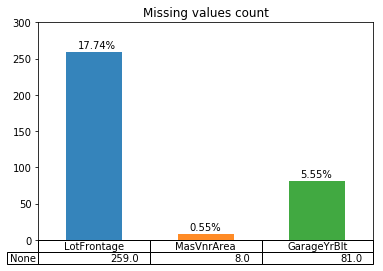

In [60]:
# Missing values# 
# number of rows
rows_length = numeric_features.shape[0]
# fields with missing value count
numeric_nan_length = numeric_features.isna().sum().where(lambda x : x > 0).dropna()
ax = numeric_nan_length \
.plot(kind='bar', alpha=0.9, title='Missing values count', table=True)
ax.xaxis.set_visible(False) # hide x axis labels
plt.ylim(0,300)

# write percentage on top of each bar
for i in ax.patches:
    ax.text(i.get_x()+.1, i.get_height()+5, \
            str(round((i.get_height()/rows_length)*100, 2))+'%')

There are three numerical features with missing values:
<ul>
<li>LotFrontage = Linear feet of street connected to property</li>
<li>MasVnrArea = Masonry veneer (trad.: impiallacciatura in muratura) area in square feet </li>
<li>GarageYrBlt = Year garage was built</li>
</ul>

In [65]:
garage_filter=train[['GarageType','GarageYrBlt']]
garage_filter = garage_filter[garage_filter['GarageType'].isna() & garage_filter['GarageYrBlt'].isna()]
print("If a house doesn't have a garage then it's 'GarageYrBlt' is NaN in {}% of the cases"
      .format((garage_filter.shape[0]/numeric_nan_length[2])*100))

If a house doesn't have a garage then it's 'GarageYrBlt' is NaN in 100.0% of the cases


There missing values of <b>GarageYrBlt</b> means that that specific house doesn't have a garage.